In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
# load utils
from src.perceptual_descriptor_selection import *
from src.make_dataset.split_data import *

# Load feature dataset, labels and hierarchy map

In [2]:
# Load the full features
X_raw = pd.read_parquet("../data/processed/features_pca_per_group_3900.parquet")
X_raw.index = X_raw.index.astype(int)

# Load labels
labels = pd.read_parquet("../data/processed/core_dataset.parquet")
labels = labels.set_index("song_id")
labels.index = labels.index.astype(int)

# Align features and labels
common_ids = X_raw.index.intersection(labels.index)

X = X_raw.loc[common_ids] # apply the alignment
y_valence = labels.loc[common_ids, "valence_mean"]
y_arousal = labels.loc[common_ids, "arousal_mean"]
y_valence_std = labels.loc[common_ids, "valence_std"]
y_arousal_std = labels.loc[common_ids, "arousal_std"]

print(f"Aligned features: {X.shape}")
print(f"Songs: {len(common_ids)}")
print("Label stats:")
print(f"  Valence mean: {y_valence.mean():.3f} ± {y_valence.std():.3f}")
print(f"  Arousal mean: {y_arousal.mean():.3f} ± {y_arousal.std():.3f}")

Aligned features: (1802, 516)
Songs: 1802
Label stats:
  Valence mean: 4.904 ± 1.174
  Arousal mean: 4.814 ± 1.282


In [3]:
# Load the hierarchy map
hierarchy_map_path = Path("../data/hierarchy_map.csv")

hierarchy_map = pd.read_csv(hierarchy_map_path)
print(f"Loaded hierarchy map with {len(hierarchy_map)} feature mappings")
print("Hierarchy map columns:", hierarchy_map.columns.tolist())
print("\nFirst few mappings:")
print(hierarchy_map.head())

Loaded hierarchy map with 260 feature mappings
Hierarchy map columns: ['feature', 'perceptual', 'musical']

First few mappings:
                      feature          perceptual   musical
0           F0final_sma_amean       melodiousness     pitch
1        F0final_sma_de_amean       melodiousness     pitch
2       F0final_sma_de_stddev     tonal_stability     pitch
3          F0final_sma_stddev     tonal_stability     pitch
4  audSpec_Rfilt_sma[0]_amean  rhythmic_stability  spectral


In [4]:
# Show hierarchy summary
print(f"\nHierarchy summary:")
perceptual_counts = hierarchy_map['perceptual'].value_counts()
print(f"Perceptual-level categories ({len(perceptual_counts)}):")
for category, count in perceptual_counts.items():
    print(f"  {category}: {count} base features")


Hierarchy summary:
Perceptual-level categories (7):
  articulation: 60 base features
  tonal_stability: 52 base features
  dissonance: 48 base features
  rhythmic_complexity: 34 base features
  unmapped: 32 base features
  rhythmic_stability: 18 base features
  melodiousness: 16 base features


# Intra feature selection analysis

In [5]:
# add mode as minorness
mode_df = pd.read_parquet("../data/processed/audio_metadata.parquet")
m = mode_df[['song_id','mode','key_confidence']].copy()
m['is_minor'] = (m['mode'].str.lower() == 'minor').astype(int)
m['minorness_score'] = (m['is_minor'] * m['key_confidence']).astype(float)
m = m.set_index('song_id').reindex(X.index)
X_pca = X.copy()
X_pca = X_pca.join(m[['minorness_score']], how='left')

In [6]:
X.columns

Index(['melodiousness_PC1', 'melodiousness_PC2', 'melodiousness_PC3',
       'melodiousness_PC4', 'melodiousness_PC5', 'melodiousness_PC6',
       'melodiousness_PC7', 'melodiousness_PC8', 'melodiousness_PC9',
       'melodiousness_PC10',
       ...
       'tonal_stability_PC152', 'tonal_stability_PC153',
       'tonal_stability_PC154', 'tonal_stability_PC155',
       'tonal_stability_PC156', 'tonal_stability_PC157',
       'tonal_stability_PC158', 'tonal_stability_PC159',
       'tonal_stability_PC160', 'tonal_stability_PC161'],
      dtype='object', length=516)

In [7]:
from importlib import reload
from src import pca_workflow
from src.make_dataset import split_data

reload(pca_workflow)
reload(split_data)

<module 'src.make_dataset.split_data' from '/home/georgios/PGMP/notebooks/../src/make_dataset/split_data.py'>

In [8]:
tr2, va2, te2 = load_splits_triplet() #custom split
cv5_splits = load_kfold_splits() #5folds

### Part 1: Pick m (number of PC features to keep inside each category) with CV on tr2 only (joint valence+arousal)

In [9]:
from src.pca_workflow import cv_over_m_joint

# Pick m with CV on dev folds
m_grid = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
df_m = cv_over_m_joint(X_pca, y_valence, y_arousal, splits=cv5_splits, m_values=m_grid)
best_m = int(df_m.loc[df_m.rmse_mean.idxmin(), 'm'])
print(df_m, "\nChosen m* =", best_m)

     m  rmse_val_mean  rmse_val_std  rmse_aro_mean  rmse_aro_std  rmse_mean
0    1       0.969122      0.049802       1.022383      0.020203   0.995752
1    2       0.945913      0.058122       0.995680      0.025782   0.970797
2    3       0.920018      0.059307       0.962943      0.011364   0.941481
3    4       0.862409      0.033446       0.883765      0.043287   0.873087
4    5       0.859599      0.030766       0.885760      0.040614   0.872680
5    6       0.861207      0.031119       0.878881      0.041812   0.870044
6    7       0.856005      0.033102       0.880929      0.039971   0.868467
7    8       0.855309      0.028246       0.883267      0.039994   0.869288
8    9       0.857383      0.030675       0.883189      0.041078   0.870286
9   10       0.854748      0.027573       0.887425      0.043908   0.871086
10  11       0.855708      0.026031       0.885374      0.044160   0.870541
11  12       0.852769      0.024795       0.883792      0.044911   0.868281
12  13      

### Part 2: Dev/val check (train on tr2, validate on va2 using train medians)

In [10]:
from src.pca_workflow import parse_pca_groups, prepare_train_eval_with_train_medians,shap_grouped_from_pcs

pca_groups = parse_pca_groups(X_pca)
m = best_m

In [11]:
# train/val
X_train_val, X_val_val = prepare_train_eval_with_train_medians(
    X_pca, train_ids=tr2, eval_ids=va2, m=m, groups=pca_groups
)

rf_val = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                               min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_val.fit(X_train_val, y_valence.loc[X_train_val.index])
pred_val_v = rf_val.predict(X_val_val)
rmse_val_v = float(np.sqrt(((y_valence.loc[X_val_val.index] - pred_val_v)**2).mean()))

rf_aro = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                               min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_aro.fit(X_train_val, y_arousal.loc[X_train_val.index])
pred_val_a = rf_aro.predict(X_val_val)
rmse_val_a = float(np.sqrt(((y_arousal.loc[X_val_val.index] - pred_val_a)**2).mean()))

print(f"Dev/val RMSE — Valence: {rmse_val_v:.4f} | Arousal: {rmse_val_a:.4f}")

Dev/val RMSE — Valence: 0.9011 | Arousal: 0.8895


In [12]:
# dev(test)
dev_ids = tr2.union(va2)
X_dev, X_test = prepare_train_eval_with_train_medians(
    X_pca, train_ids=dev_ids, eval_ids=te2, m=m, groups=pca_groups
)

rf_val.fit(X_dev, y_valence.loc[X_dev.index]);  p_test_v = rf_val.predict(X_test)
rf_aro.fit(X_dev, y_arousal.loc[X_dev.index]);  p_test_a = rf_aro.predict(X_test)

rmse_test_v = float(np.sqrt(((y_valence.loc[X_test.index] - p_test_v)**2).mean()))
rmse_test_a = float(np.sqrt(((y_arousal.loc[X_test.index] - p_test_a)**2).mean()))
print(f"Test RMSE — Valence: {rmse_test_v:.4f} | Arousal: {rmse_test_a:.4f}")

Test RMSE — Valence: 0.9801 | Arousal: 0.9576


### Par 3: SHAP interpretability analysis

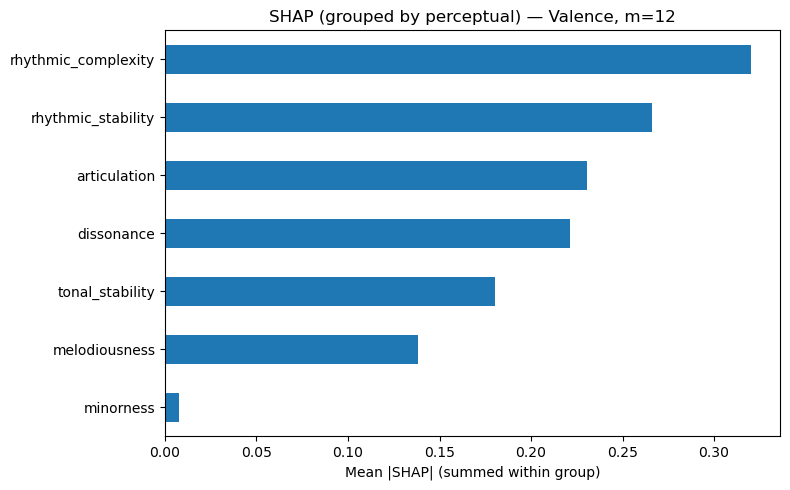

In [13]:
from src.pca_workflow import shap_grouped_from_pcs

# grouped SHAP importances (sum of |SHAP| per perceptual group)
grp_importance, expl_v, bg_v, sv = shap_grouped_from_pcs(rf_val, X_dev, pca_groups)

ax = (grp_importance.head(12).sort_values(ascending=True)
        .plot(kind='barh', figsize=(8,5)))
ax.set_title(f"SHAP (grouped by perceptual) — Valence, m={best_m}")
ax.set_xlabel("Mean |SHAP| (summed within group)")
plt.tight_layout(); plt.show()

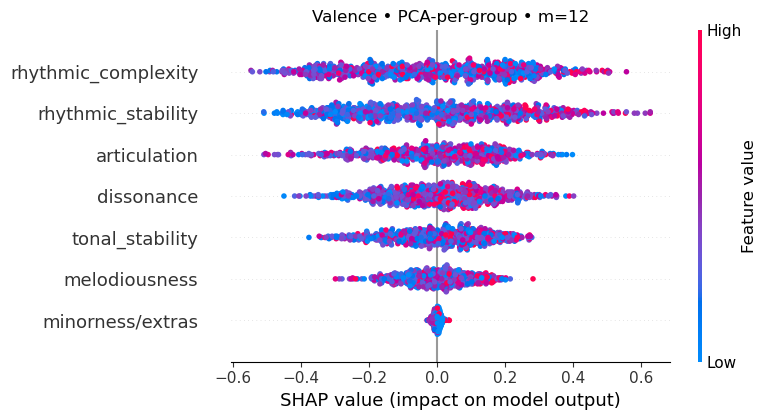

In [14]:
from src.pca_workflow import shap_grouped_beeswarm

shap_grouped_beeswarm(rf_val, X_dev, pca_groups, max_display=12,
                             title=f"Valence • PCA-per-group • m={best_m}")

### Part 4: Model family check for the chosen m

In [15]:
from sklearn.metrics import mean_squared_error

pca_groups = parse_pca_groups(X_pca)
m = best_m

In [16]:
from src.pca_workflow import cv_models_on_pca
# model leaderboard on VALENCE (dev CV)
board_v = cv_models_on_pca(X_pca, y_valence, cv5_splits, m, pca_groups)
print("Valence leaderboard:\n", board_v)

# model leaderboard on AROUSAL (dev CV)
board_a = cv_models_on_pca(X_pca, y_arousal, cv5_splits, m, pca_groups)
print("\nArousal leaderboard:\n", board_a)

Valence leaderboard:
         model  rmse_mean  rmse_std
0          RF   0.861209  0.034705
1       Ridge   0.863223  0.023111
2         GBR   0.866899  0.014076
3  ElasticNet   0.870453  0.029580
4         SVR   0.879833  0.021308

Arousal leaderboard:
         model  rmse_mean  rmse_std
0         GBR   0.883896  0.035522
1         SVR   0.893218  0.012540
2          RF   0.895825  0.036287
3  ElasticNet   0.920009  0.044422
4       Ridge   0.931840  0.049242


In [18]:
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
# pick one model family to keep things consistent (smallest average rank across the two boards)
rank_v = board_v.assign(rank=lambda d: d['rmse_mean'].rank()).set_index('model')['rank']
rank_a = board_a.assign(rank=lambda d: d['rmse_mean'].rank()).set_index('model')['rank']
avg_rank = (rank_v.add(rank_a, fill_value=0) / 2).sort_values()
chosen_model_name = avg_rank.index[0]
print("\nChosen model:", chosen_model_name)

# re-instantiate the chosen model (same defaults as above)
model_zoo = {
    "RF":   RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                  min_samples_leaf=2, random_state=42, n_jobs=-1),
    "GBR":  GradientBoostingRegressor(random_state=42),
    "Ridge":Pipeline([("sc", StandardScaler()), ("ridge", RidgeCV(alphas=np.logspace(-3,3,13)))]),
    "ElasticNet":Pipeline([("sc", StandardScaler()), ("enet", ElasticNetCV(l1_ratio=[.1,.5,.9,1.0],
                                                                           alphas=np.logspace(-3,1,12),
                                                                           random_state=42))]),
    "SVR":  Pipeline([("sc", StandardScaler()), ("svr", SVR(C=3.0, epsilon=0.1))]),
}
Model = model_zoo[chosen_model_name]


Chosen model: GBR


In [19]:
# build DEV (tr2+va2) and TEST designs once
from sklearn.base import clone

dev_ids = tr2.union(va2)
X_dev, X_test = prepare_train_eval_with_train_medians(
    X_pca, train_ids=dev_ids, eval_ids=te2, m=m, groups=pca_groups
)

# fit valence + test
model_val = clone(Model) if hasattr(Model, 'get_params') else Model
model_val.fit(X_dev, y_valence.loc[X_dev.index])
p_test_v = model_val.predict(X_test)
rmse_test_v = float(np.sqrt(mean_squared_error(y_valence.loc[X_test.index], p_test_v)))

# fit arousal + test
model_aro = clone(Model) if hasattr(Model, 'get_params') else Model
model_aro.fit(X_dev, y_arousal.loc[X_dev.index])
p_test_a = model_aro.predict(X_test)
rmse_test_a = float(np.sqrt(mean_squared_error(y_arousal.loc[X_test.index], p_test_a)))

print(f"\nTEST — {chosen_model_name}")
print(f"  Valence RMSE: {rmse_test_v:.4f}")
print(f"  Arousal RMSE: {rmse_test_a:.4f}")


TEST — GBR
  Valence RMSE: 0.9859
  Arousal RMSE: 0.9261


In [21]:
#permutation test on the chosen pca model
from src.pca_workflow import permutation_rmse, build_X_pca_m

groups = parse_pca_groups(X_pca)
def build_fold_X_pca(tr, va):
    Xtr = build_X_pca_m(X_pca.loc[tr], best_m, groups)
    med = Xtr.median(numeric_only=True)
    Xtr = Xtr.fillna(med)
    Xva = build_X_pca_m(X_pca.loc[va], best_m, groups).fillna(med)
    return Xtr, Xva

real, null_mu, null_sd, p = permutation_rmse(build_fold_X_pca, y_valence, cv5_splits)

In [22]:
dev_ids = tr2.union(va2)  # All development data
groups = parse_pca_groups(X_pca)

# Build the final feature matrix with m PCs per group
Xm = build_X_pca_m(X_pca, best_m, groups)

# Impute with development set medians
dev_medians = Xm.loc[dev_ids].median(numeric_only=True)
Xm = Xm.fillna(dev_medians)

### Analyze final features' correlation

In [23]:
import seaborn as sns

# Build dev matrix
dev_ids = tr2.union(va2)
X_dev, _ = prepare_train_eval_with_train_medians(
    X_pca, train_ids=dev_ids, eval_ids=dev_ids, m=best_m, groups=pca_groups
)

In [24]:
# put groups first, then extras for a nicer order
ordered_cols = []
for g in [k for k in pca_groups.keys() if k != '__extras__']:
    pcs = [c for c in X_dev.columns if c.startswith(f"{g}_PC")]
    ordered_cols.extend(pcs[:min(best_m, len(pcs))])
if '__extras__' in pca_groups:
    ordered_cols.extend([c for c in X_dev.columns if c in pca_groups['__extras__']])

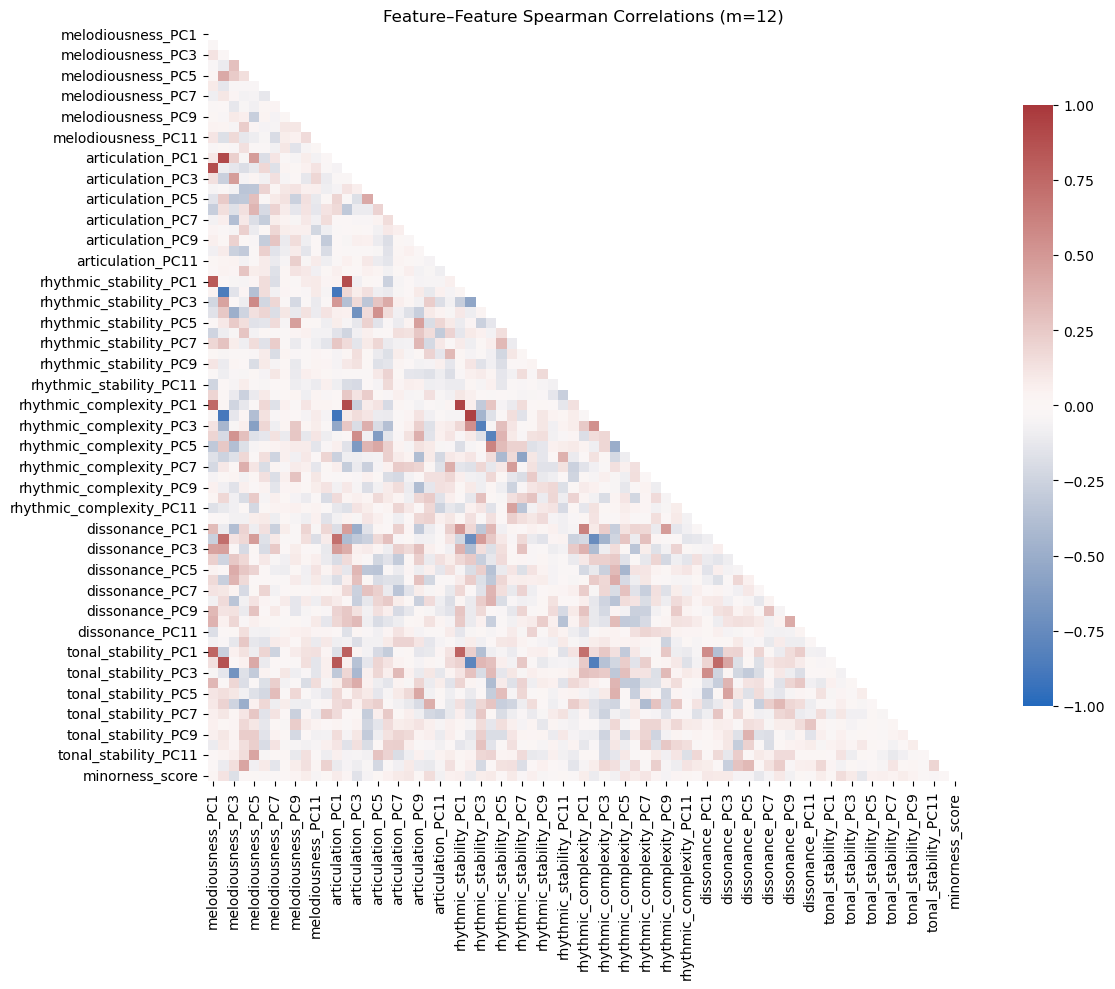

In [25]:
X_dev = X_dev[ordered_cols]

# Spearman feature-feature correlations
corr = X_dev.corr(method='spearman')

# Plot (mask upper triangle to declutter)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(14, 10))
sns.heatmap(corr, mask=mask, cmap="vlag", vmin=-1, vmax=1, center=0,
            square=True, cbar_kws={'shrink': .8})
plt.title(f"Feature–Feature Spearman Correlations (m={best_m})")
plt.tight_layout()
plt.show()

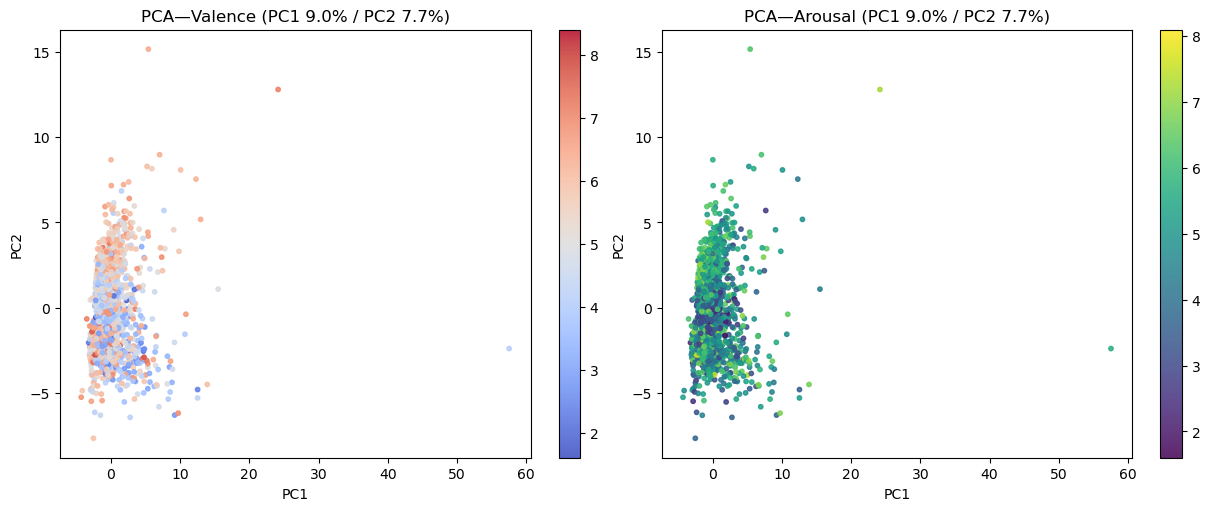

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

idx = Xm.index.intersection(y_valence.index).intersection(y_arousal.index)
Z = StandardScaler().fit_transform(Xm.loc[idx].fillna(Xm.loc[idx].median()))
p = PCA(n_components=2, random_state=42).fit(Z)
PC = p.transform(Z); v1,v2 = p.explained_variance_ratio_*100

va = y_valence.loc[idx].astype(float).values
ar = y_arousal.loc[idx].astype(float).values

fig, ax = plt.subplots(1,2,figsize=(12,5), constrained_layout=True)
s=ax[0].scatter(PC[:,0],PC[:,1],c=va,s=10,cmap='coolwarm',alpha=.85)
ax[0].set(title=f"PCA—Valence (PC1 {v1:.1f}% / PC2 {v2:.1f}%)",xlabel='PC1',ylabel='PC2'); fig.colorbar(s,ax=ax[0])
s=ax[1].scatter(PC[:,0],PC[:,1],c=ar,s=10,cmap='viridis',alpha=.85)
ax[1].set(title=f"PCA—Arousal (PC1 {v1:.1f}% / PC2 {v2:.1f}%)",xlabel='PC1',ylabel='PC2'); fig.colorbar(s,ax=ax[1])
plt.show()

In [27]:
# Fit PCA on the selected per-base features
Xf = Xm.fillna(Xm.median())
Z  = StandardScaler().fit_transform(Xf)
pca = PCA(n_components=2, random_state=42).fit(Z)

scores   = pd.DataFrame(pca.transform(Z), index=Xf.index, columns=['PC1','PC2'])
loadings = pd.DataFrame(pca.components_.T, index=Xf.columns, columns=['PC1','PC2'])
expl_var = pca.explained_variance_ratio_
print(f"Explained variance: PC1={expl_var[0]:.2%}, PC2={expl_var[1]:.2%}")

# How PCs relate to Valence/Arousal (Spearman = robust)
corrs = scores.assign(valence=y_valence.loc[scores.index],
                      arousal=y_arousal.loc[scores.index]) \
              .corr(method='spearman').loc[['PC1','PC2'], ['valence','arousal']]
print(corrs)

Explained variance: PC1=8.98%, PC2=7.74%
      valence   arousal
PC1 -0.063762 -0.022481
PC2  0.240317  0.131204


## Split on custom set and Normalize features

In [28]:
train_ids_custom, val_ids_custom, test_ids_custom = load_splits_triplet()

In [29]:
from src.normalization import SplitScaler

# Split the data
X_train_custom = Xm.loc[train_ids_custom]
X_val_custom = Xm.loc[val_ids_custom]
X_test_custom = Xm.loc[test_ids_custom]

In [30]:
# Normalize
scaler = SplitScaler()
X_train_scaled_custom = scaler.fit_transform(X_train_custom)
X_val_scaled_custom = scaler.transform(X_val_custom)
X_test_scaled_custom = scaler.transform(X_test_custom)
print(f"Train: {X_train_scaled_custom.shape}")
print(f"Val: {X_val_scaled_custom.shape}")
print(f"Test: {X_test_scaled_custom.shape}")

Train: (1257, 73)
Val: (276, 73)
Test: (269, 73)


# Save everything

In [31]:
import joblib

output_dir = Path("../data/processed/derived/exp6_pca_per_group_3900")
output_dir.mkdir(exist_ok=True)

In [32]:
output_dir_custom = Path(output_dir / "custom_split/")
output_dir_custom.mkdir(exist_ok=True)
# Save splits
X_train_scaled_custom.to_parquet(output_dir_custom / "X_train_scaled_custom.parquet")
X_val_scaled_custom.to_parquet(output_dir_custom / "X_val_scaled_custom.parquet")
X_test_scaled_custom.to_parquet(output_dir_custom / "X_test_scaled_custom.parquet")

# Save targets
y_valence.loc[train_ids_custom].to_csv(output_dir_custom / "y_valence_train_custom.csv")
y_valence.loc[val_ids_custom].to_csv(output_dir_custom / "y_valence_val_custom.csv")
y_valence.loc[test_ids_custom].to_csv(output_dir_custom / "y_valence_test_custom.csv")

y_arousal.loc[train_ids_custom].to_csv(output_dir_custom / "y_arousal_train_custom.csv")
y_arousal.loc[val_ids_custom].to_csv(output_dir_custom / "y_arousal_val_custom.csv")
y_arousal.loc[test_ids_custom].to_csv(output_dir_custom / "y_arousal_test_custom.csv")

# Save scaler and config
joblib.dump(scaler, output_dir / "scaler.pkl")

print(f"\nAll features saved to {output_dir}/")
print(f"Final dataset shape: {Xm.shape}")


All features saved to ../data/processed/derived/exp6_pca_per_group_3900/
Final dataset shape: (1802, 73)


In [41]:
X_train_scaled_custom.head(2)

,melodiousness_PC1,melodiousness_PC2,melodiousness_PC3,melodiousness_PC4,melodiousness_PC5,melodiousness_PC6,melodiousness_PC7,melodiousness_PC8,melodiousness_PC9,melodiousness_PC10,...,tonal_stability_PC4,tonal_stability_PC5,tonal_stability_PC6,tonal_stability_PC7,tonal_stability_PC8,tonal_stability_PC9,tonal_stability_PC10,tonal_stability_PC11,tonal_stability_PC12,minorness_score
song_id,,,,,,,,,,,,,,,,,,,,,
2,-0.659464,-0.629250,-0.622578,-0.892392,-0.265785,-0.489864,0.290028,0.226842,-0.701706,-1.637593,...,0.862026,-1.591859,1.045914,-1.955832,-0.526474,0.611090,1.051978,-0.473169,-0.747955,-0.182488
3,-0.278959,-2.001049,-1.911867,-0.811143,2.828389,-1.008567,0.917396,0.165156,-1.583100,-2.073322,...,1.381043,-1.658586,1.727706,1.118784,0.711574,1.725994,1.675614,0.896056,-1.226608,1.025649


# Model Test on Custom Split

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path

output_dir_custom = Path("../data/processed/derived/exp6_pca_per_group_3900/custom_split/")

In [2]:
# Load scaled feature data for the custom split
X_train_scaled_custom = pd.read_parquet(output_dir_custom / "X_train_scaled_custom.parquet")
X_val_scaled_custom = pd.read_parquet(output_dir_custom / "X_val_scaled_custom.parquet")
X_test_scaled_custom = pd.read_parquet(output_dir_custom / "X_test_scaled_custom.parquet")

# Load target data for the custom split
y_valence_train_custom = pd.read_csv(output_dir_custom / "y_valence_train_custom.csv", index_col=0)
y_valence_val_custom = pd.read_csv(output_dir_custom / "y_valence_val_custom.csv", index_col=0)
y_valence_test_custom = pd.read_csv(output_dir_custom / "y_valence_test_custom.csv", index_col=0)

y_arousal_train_custom = pd.read_csv(output_dir_custom / "y_arousal_train_custom.csv", index_col=0)
y_arousal_val_custom = pd.read_csv(output_dir_custom / "y_arousal_val_custom.csv", index_col=0)
y_arousal_test_custom = pd.read_csv(output_dir_custom / "y_arousal_test_custom.csv", index_col=0)

In [3]:
# Align data for consistent samples
y_train_target_custom = y_valence_train_custom.squeeze().reindex(X_train_scaled_custom.index).dropna()
X_train_scaled_custom = X_train_scaled_custom.reindex(y_train_target_custom.index)

y_val_target_custom = y_valence_val_custom.squeeze().reindex(X_val_scaled_custom.index).dropna()
X_val_scaled_custom = X_val_scaled_custom.reindex(y_val_target_custom.index)

y_test_target_custom = y_valence_test_custom.squeeze().reindex(X_test_scaled_custom.index).dropna()
X_test_scaled_custom = X_test_scaled_custom.reindex(y_test_target_custom.index)

y_aro_train_custom = y_arousal_train_custom.squeeze().reindex(X_train_scaled_custom.index).dropna()
y_aro_val_custom = y_arousal_val_custom.squeeze().reindex(X_val_scaled_custom.index).dropna()
y_aro_test_custom = y_arousal_test_custom.squeeze().reindex(X_test_scaled_custom.index).dropna()

print("Custom Split Data loaded and aligned. Shapes:")
print(f"X_train: {X_train_scaled_custom.shape}, y_valence_train: {y_train_target_custom.shape}")
print(f"X_val: {X_val_scaled_custom.shape}, y_valence_val: {y_val_target_custom.shape}")
print(f"X_test: {X_test_scaled_custom.shape}, y_valence_test: {y_test_target_custom.shape}")

Custom Split Data loaded and aligned. Shapes:
X_train: (1257, 73), y_valence_train: (1257,)
X_val: (276, 73), y_valence_val: (276,)
X_test: (269, 73), y_valence_test: (269,)


In [4]:
# Valence Model
model_valence_custom = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                           min_samples_leaf=2, random_state=42, n_jobs=-1)
model_valence_custom.fit(X_train_scaled_custom, y_train_target_custom)

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [5]:
# Predictions
y_pred_val_custom = model_valence_custom.predict(X_val_scaled_custom)
y_pred_test_custom = model_valence_custom.predict(X_test_scaled_custom)

# Metrics
mse_val_custom = mean_squared_error(y_val_target_custom, y_pred_val_custom)
rmse_val_custom = np.sqrt(mse_val_custom)
r2_val_custom = r2_score(y_val_target_custom, y_pred_val_custom)

mse_test_custom = mean_squared_error(y_test_target_custom, y_pred_test_custom)
rmse_test_custom = np.sqrt(mse_test_custom)
r2_test_custom = r2_score(y_test_target_custom, y_pred_test_custom)

print("\n--- Custom Split Performance ---")
print(f"\nValidation set performance (Valence):")
print(f"  RMSE: {rmse_val_custom:.4f}")
print(f"  R²:   {r2_val_custom:.4f}")

print(f"\nTest set performance (Valence):")
print(f"  RMSE: {rmse_test_custom:.4f}")
print(f"  R²:   {r2_test_custom:.4f}")


--- Custom Split Performance ---

Validation set performance (Valence):
  RMSE: 0.9011
  R²:   0.4120

Test set performance (Valence):
  RMSE: 0.9882
  R²:   0.2880


In [6]:
# Arousal Model
model_arousal_custom = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                           min_samples_leaf=2, random_state=42, n_jobs=-1)
model_arousal_custom.fit(X_train_scaled_custom, y_aro_train_custom)


,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
# Predictions
y_pred_aro_val_custom = model_arousal_custom.predict(X_val_scaled_custom)
y_pred_aro_test_custom = model_arousal_custom.predict(X_test_scaled_custom)

# Metrics
mse_aro_val_custom = mean_squared_error(y_aro_val_custom, y_pred_aro_val_custom)
rmse_aro_val_custom = np.sqrt(mse_aro_val_custom)
r2_aro_val_custom = r2_score(y_aro_val_custom, y_pred_aro_val_custom)

mse_aro_test_custom = mean_squared_error(y_aro_test_custom, y_pred_aro_test_custom)
rmse_aro_test_custom = np.sqrt(mse_aro_test_custom)
r2_aro_test_custom = r2_score(y_aro_test_custom, y_pred_aro_test_custom)

print(f"\nValidation set performance (Arousal):")
print(f"  RMSE: {rmse_aro_val_custom:.4f}")
print(f"  R²:   {r2_aro_val_custom:.4f}")

print(f"\nTest set performance (Arousal):")
print(f"  RMSE: {rmse_aro_test_custom:.4f}")
print(f"  R²:   {r2_aro_test_custom:.4f}")


Validation set performance (Arousal):
  RMSE: 0.8895
  R²:   0.5513

Test set performance (Arousal):
  RMSE: 0.9580
  R²:   0.4612


In [9]:
from pathlib import Path
import sys
sys.path.append('..')
from src.utils import save_results

In [10]:
# Group the metrics for the custom split
custom_split = {
    "Valence": {
        "Validation": {"RMSE": rmse_val_custom, "R2": r2_val_custom},
        "Test": {"RMSE": rmse_test_custom, "R2": r2_test_custom}
    },
    "Arousal": {
        "Validation": {"RMSE": rmse_aro_val_custom, "R2": r2_aro_val_custom},
        "Test": {"RMSE": rmse_aro_test_custom, "R2": r2_aro_test_custom}
    }
}

# Save the results for the custom split
save_results(
    name="exp6/RF_Custom_Split",
    history={},
    test_metrics=custom_split,
    save_dir=Path("../results/ML/")
)

In [11]:
import json

with open("../results/ML/exp6/RF_Custom_Split.json", 'r') as f:
    results_custom = json.load(f)

In [12]:
print("--- Model Performance on Test Set ---")

custom_metrics = results_custom['test_metrics']
v_rmse_custom = custom_metrics['Valence']['Test']['RMSE']
v_r2_custom = custom_metrics['Valence']['Test']['R2']
a_rmse_custom = custom_metrics['Arousal']['Test']['RMSE']
a_r2_custom = custom_metrics['Arousal']['Test']['R2']

print("\nCustom Split:")
print(f"  - Valence: RMSE = {v_rmse_custom:.4f}, R2 = {v_r2_custom:.4f}")
print(f"  - Arousal: RMSE = {a_rmse_custom:.4f}, R2 = {a_r2_custom:.4f}")

--- Model Performance on Test Set ---

Custom Split:
  - Valence: RMSE = 0.9882, R2 = 0.2880
  - Arousal: RMSE = 0.9580, R2 = 0.4612
